In [1]:
pip install pandas numpy matplotlib seaborn statsmodels ipywidgets

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ipywidgets as widgets
from ipywidgets import interact
import warnings

### Load the Data

In [3]:
df_sales = pd.read_csv('slooze_challenge/SalesFINAL12312016.csv')
df_purchases = pd.read_csv('slooze_challenge/PurchasesFINAL12312016.csv')
df_invoices = pd.read_csv('slooze_challenge/InvoicePurchases12312016.csv')
df_inv_begin = pd.read_csv('slooze_challenge/BegInvFINAL12312016.csv')
df_inv_end = pd.read_csv('slooze_challenge/EndInvFINAL12312016.csv')
df_prices = pd.read_csv('slooze_challenge/2017PurchasePricesDec.csv') # Optional if needed

In [4]:
df_invoices.columns

Index(['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate',
       'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval'],
      dtype='object')

### Data Cleaning

In [5]:
# Convert date columns to datetime objects
df_sales['SalesDate'] = pd.to_datetime(df_sales['SalesDate'])
df_inv_begin['startDate'] = pd.to_datetime(df_inv_begin['startDate'])
df_inv_end['endDate'] = pd.to_datetime(df_inv_end['endDate'])

# Corrected Invoice Dates
df_invoices['InvoiceDate'] = pd.to_datetime(df_invoices['InvoiceDate'])
df_invoices['PODate'] = pd.to_datetime(df_invoices['PODate'])
df_invoices['PayDate'] = pd.to_datetime(df_invoices['PayDate'])

### Master Dataset Creation

CREATING DAILY DEMAND

In [6]:
# Aggregate sales by Date and Item
daily_demand = df_sales.groupby(['SalesDate', 'InventoryId', 'Description'])['SalesQuantity'].sum().reset_index()
daily_demand.rename(columns={'SalesQuantity': 'Demand_Units'}, inplace=True)

CREATE INVENTORY MASTER

In [7]:
# Merge Beginning and Ending Inventory
inv_start = df_inv_begin.rename(columns={'onHand': 'Begin_Qty', 'startDate': 'Begin_Date'})[['InventoryId', 'Store', 'Begin_Qty', 'Begin_Date']]
inv_end = df_inv_end.rename(columns={'onHand': 'End_Qty', 'endDate': 'End_Date'})[['InventoryId', 'Store', 'End_Qty', 'End_Date']]

df_inventory_master = pd.merge(inv_start, inv_end, on=['InventoryId', 'Store'], how='outer').fillna(0)
df_inventory_master['Avg_Inventory'] = (df_inventory_master['Begin_Qty'] + df_inventory_master['End_Qty']) / 2

 ENRICH SALES WITH COST

In [8]:

# Get average purchase price per item
item_costs = df_purchases.groupby('InventoryId')['PurchasePrice'].mean().reset_index()
item_costs.rename(columns={'PurchasePrice': 'Unit_Cost'}, inplace=True)

In [9]:
# Merge cost into sales data
df_sales_enriched = pd.merge(df_sales, item_costs, on='InventoryId', how='left')
# Drop rows with missing cost info (approx 3-4%) to ensure accurate profit analysis
df_sales_enriched.dropna(subset=['Unit_Cost'], inplace=True)

In [10]:
# Calculate Margin
df_sales_enriched['Gross_Profit'] = df_sales_enriched['SalesPrice'] - df_sales_enriched['Unit_Cost']

print("✅ Data Cleaning & Integration Complete.")
print(f"   - Daily Demand Records: {len(daily_demand):,}")
print(f"   - Inventory Master Records: {len(df_inventory_master):,}")
print(f"   - Enriched Sales Records: {len(df_sales_enriched):,}")

✅ Data Cleaning & Integration Complete.
   - Daily Demand Records: 1,048,575
   - Inventory Master Records: 256,042
   - Enriched Sales Records: 1,008,518


### EDA

/var/folders/ss/dz63pck12hqg6zy145k1_4zr0000gn/T/ipykernel_73091/1184917621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_rev, x='Store', y='SalesDollars', palette='viridis', order=store_rev['Store'])


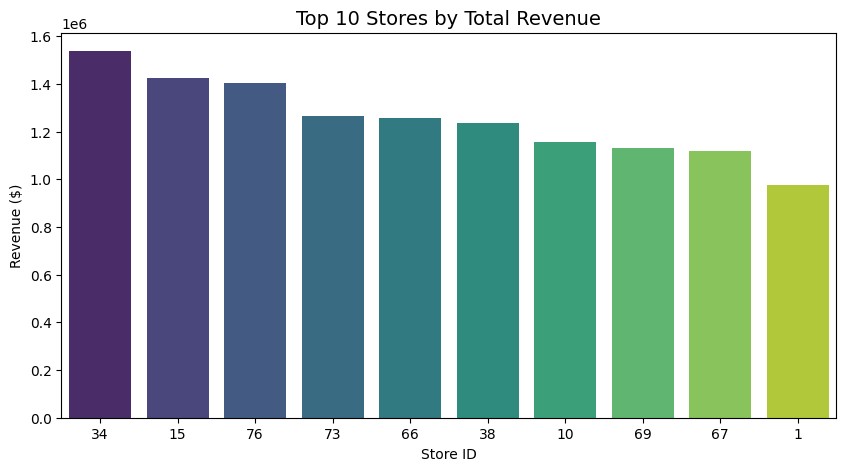

In [11]:
# --- 1. TOP 10 STORES BY REVENUE ---
store_rev = df_sales.groupby('Store')['SalesDollars'].sum().nlargest(10).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=store_rev, x='Store', y='SalesDollars', palette='viridis', order=store_rev['Store'])
plt.title('Top 10 Stores by Total Revenue', fontsize=14)
plt.ylabel('Revenue ($)')
plt.xlabel('Store ID')
plt.show()

/var/folders/ss/dz63pck12hqg6zy145k1_4zr0000gn/T/ipykernel_73091/2110413481.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_sales.set_index('SalesDate').resample('M')['SalesDollars'].sum().reset_index()


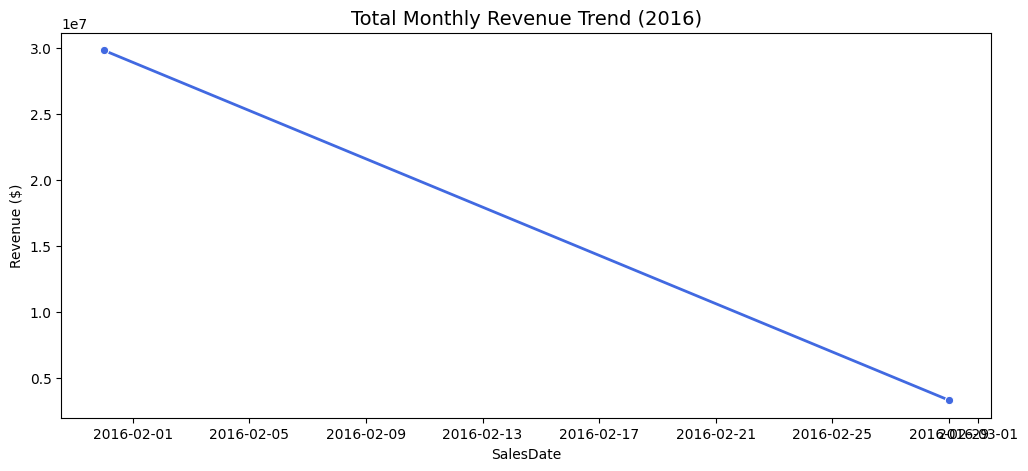

In [12]:
# --- 2. SALES TREND (MONTHLY) ---
# Resample to monthly frequency for cleaner trend line
monthly_sales = df_sales.set_index('SalesDate').resample('M')['SalesDollars'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='SalesDate', y='SalesDollars', marker='o', color='royalblue', linewidth=2)
plt.title('Total Monthly Revenue Trend (2016)', fontsize=14)
plt.ylabel('Revenue ($)')
plt.show()

### Forecasting

In [13]:
# 1. Identify Top Product by Volume
top_product_id = daily_demand.groupby('InventoryId')['Demand_Units'].sum().idxmax()
top_product_name = daily_demand[daily_demand['InventoryId'] == top_product_id]['Description'].iloc[0]


In [14]:
# 2. Filter Data for this product
prod_ts = daily_demand[daily_demand['InventoryId'] == top_product_id].set_index('SalesDate')['Demand_Units']
prod_ts = prod_ts.resample('D').sum().fillna(0) # Ensure daily frequency


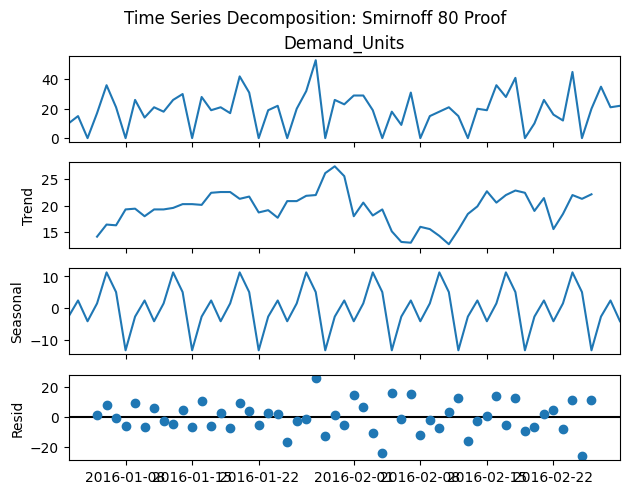

In [15]:
# 3. Seasonal Decomposition (Visualize Trend/Seasonality)
result = seasonal_decompose(prod_ts, model='additive', period=7)
result.plot()
plt.suptitle(f'Time Series Decomposition: {top_product_name}', y=1.02)
plt.show()

Training Model for: Smirnoff 80 Proof...


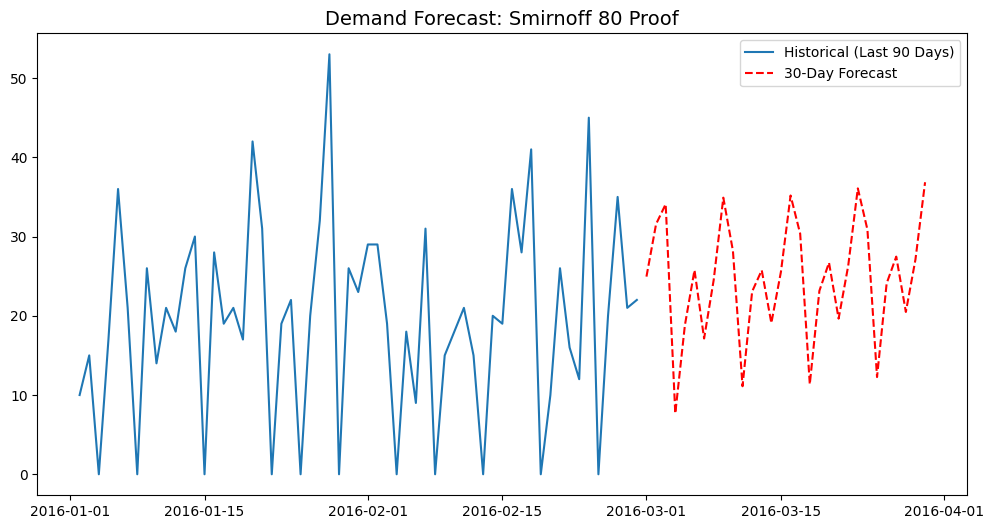

In [16]:
# 4. Simple SARIMA Forecast (Example)
# Note: In a real scenario, you'd optimize p,d,q parameters
print(f"Training Model for: {top_product_name}...")
model = SARIMAX(prod_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)) # Weekly seasonality assumption
model_fit = model.fit(disp=False)

# Forecast next 30 days
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=prod_ts.index[-1], periods=31, freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plot History + Forecast
plt.figure(figsize=(12, 6))
plt.plot(prod_ts.index[-90:], prod_ts.tail(90), label='Historical (Last 90 Days)')
plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='30-Day Forecast')
plt.title(f'Demand Forecast: {top_product_name}', fontsize=14)
plt.legend()
plt.show()  

### ABC Analysis

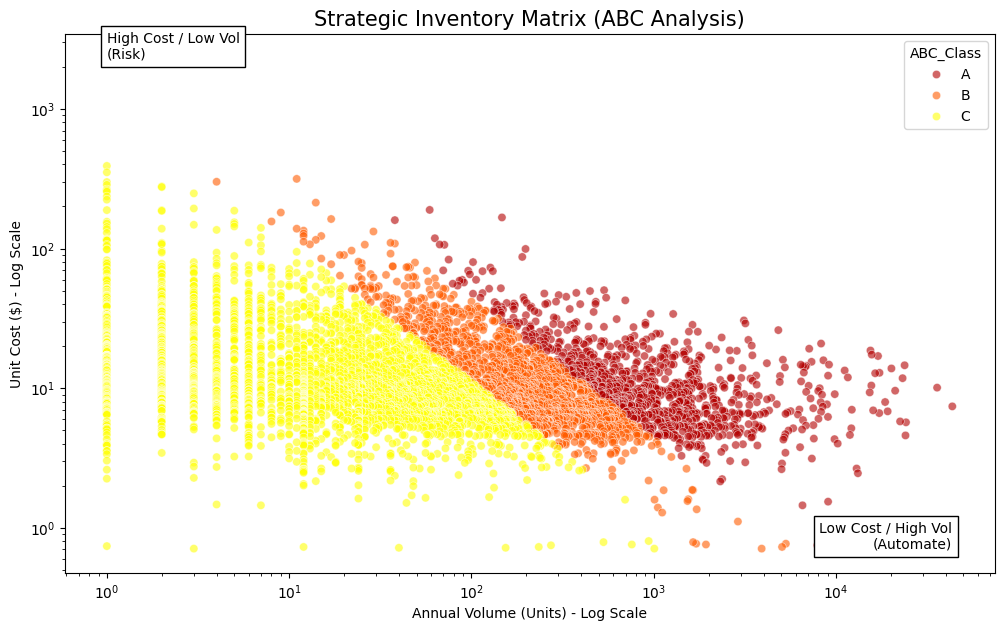

ABC_Class
C    3447
B    1437
A     941
Name: count, dtype: int64


In [17]:
# --- 1. CALCULATE ABC METRICS ---
abc_df = df_sales_enriched.groupby('Description').agg(
    Total_Units=('SalesQuantity', 'sum'),
    Unit_Cost=('Unit_Cost', 'mean'),
    Total_Value=('SalesDollars', 'sum')
).reset_index()

# Calculate Consumption Value (Cost * Volume) - Best for Supply Chain
abc_df['Consumption_Value'] = abc_df['Total_Units'] * abc_df['Unit_Cost']
abc_df = abc_df.sort_values(by='Consumption_Value', ascending=False)

# Calculate Cumulative %
abc_df['Cumulative_Val_Pct'] = abc_df['Consumption_Value'].cumsum() / abc_df['Consumption_Value'].sum()

# Assign Classes
def get_abc_class(x):
    if x <= 0.80: return 'A'
    elif x <= 0.95: return 'B'
    else: return 'C'

abc_df['ABC_Class'] = abc_df['Cumulative_Val_Pct'].apply(get_abc_class)

# --- 2. STRATEGIC INVENTORY MATRIX PLOT ---
plt.figure(figsize=(12, 7))
# Filter positive values for log scale
plot_data = abc_df[(abc_df['Total_Units'] > 0) & (abc_df['Unit_Cost'] > 0)]

sns.scatterplot(data=plot_data, x='Total_Units', y='Unit_Cost', hue='ABC_Class', palette='hot', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title('Strategic Inventory Matrix (ABC Analysis)', fontsize=15)
plt.xlabel('Annual Volume (Units) - Log Scale')
plt.ylabel('Unit Cost ($) - Log Scale')

# Add Quadrant Labels
plt.text(plot_data['Total_Units'].min(), plot_data['Unit_Cost'].max(), "High Cost / Low Vol\n(Risk)", bbox=dict(facecolor='white'))
plt.text(plot_data['Total_Units'].max(), plot_data['Unit_Cost'].min(), "Low Cost / High Vol\n(Automate)", ha='right', bbox=dict(facecolor='white'))
plt.show()

print(abc_df['ABC_Class'].value_counts())

### EOQ & JIT

In [18]:
# --- PREPARE DATA FOR EOQ ---
# Calculate Demand Volatility (CV) to find JIT candidates
# (CV < 0.5 means demand is stable/predictable)
volatility = daily_demand.groupby('Description')['Demand_Units'].agg(['mean', 'std']).reset_index()
volatility['CV'] = volatility['std'] / volatility['mean']
volatility['CV'] = volatility['CV'].fillna(0) # Handle single-sale items

# Merge with ABC Data
eoq_data = pd.merge(abc_df, volatility[['Description', 'CV']], on='Description')

# --- INTERACTIVE EOQ CALCULATOR & PLOT ---
def plot_eoq_simulation(order_cost, holding_cost_pct):
    # 1. Calculate EOQ for all items
    eoq_data['Holding_Cost_Unit'] = eoq_data['Unit_Cost'] * (holding_cost_pct / 100)
    
    # Avoid division by zero
    eoq_data['Holding_Cost_Unit'] = eoq_data['Holding_Cost_Unit'].replace(0, 0.01)
    
    eoq_data['EOQ'] = np.sqrt((2 * eoq_data['Total_Units'] * order_cost) / eoq_data['Holding_Cost_Unit'])
    
    # Identify JIT Candidates (Stable A-Items)
    jit_items = eoq_data[(eoq_data['ABC_Class'] == 'A') & (eoq_data['CV'] < 0.5)]
    
    # --- 2. PLOT: Cost Curve for the #1 JIT Candidate ---
    if not jit_items.empty:
        # Pick the top candidate to visualize
        top_item = jit_items.sort_values(by='Total_Units', ascending=False).iloc[0]
        
        # Create a range of possible order quantities (from 1 to 3x EOQ)
        eoq_val = int(top_item['EOQ'])
        quantities = np.linspace(max(1, eoq_val - 50), eoq_val + 50, 100)
        
        # Calculate Costs for the curve
        ordering_costs = (top_item['Total_Units'] / quantities) * order_cost
        holding_costs = (quantities / 2) * top_item['Holding_Cost_Unit']
        total_costs = ordering_costs + holding_costs
        
        # Draw the Plot
        plt.figure(figsize=(10, 6))
        plt.plot(quantities, total_costs, label='Total Cost', color='black', linewidth=2)
        plt.plot(quantities, ordering_costs, label='Ordering Cost', linestyle='--', color='blue', alpha=0.6)
        plt.plot(quantities, holding_costs, label='Holding Cost', linestyle='--', color='orange', alpha=0.6)
        
        # Mark the Optimal Point
        min_cost = min(total_costs)
        plt.scatter([eoq_val], [min_cost], color='red', s=100, zorder=5, label=f'Optimal EOQ ({eoq_val} units)')
        
        plt.title(f"EOQ Cost Optimization for: {top_item['Description']}", fontsize=14)
        plt.xlabel('Order Quantity (Units)')
        plt.ylabel('Annual Cost ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No JIT candidates found with current settings.")

    # --- 3. Text Summary ---
    print(f"--- SIMULATION RESULTS ---")
    print(f"JIT Candidates Identified: {len(jit_items)} products (Stable A-Items)")
    print("\nTop 5 Candidates for Auto-Replenishment:")
    print(jit_items[['Description', 'Total_Units', 'EOQ', 'CV']].head(5))

# Create Widget
interact(plot_eoq_simulation, 
         order_cost=widgets.IntSlider(min=10, max=100, step=10, value=50, description='Order Cost $'),
         holding_cost_pct=widgets.IntSlider(min=5, max=40, step=5, value=20, description='Holding %'));

interactive(children=(IntSlider(value=50, description='Order Cost $', min=10, step=10), IntSlider(value=20, de…

### Vendor Performance

/var/folders/ss/dz63pck12hqg6zy145k1_4zr0000gn/T/ipykernel_73091/3209170817.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vendor_perf, x='Lead_Time', y='VendorName', palette='coolwarm')


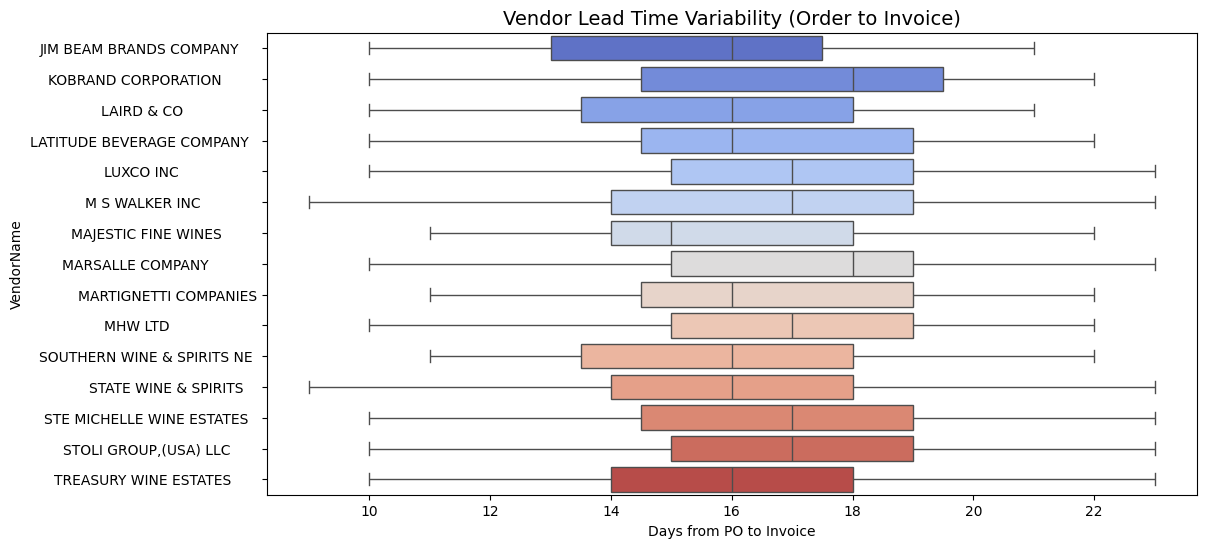

Average Lead Time: 16.4 days


In [19]:
# --- VENDOR LEAD TIME ANALYSIS (CORRECTED) ---

# 1. Ensure dates are in datetime format (just in case)
df_invoices['InvoiceDate'] = pd.to_datetime(df_invoices['InvoiceDate'])
df_invoices['PODate'] = pd.to_datetime(df_invoices['PODate'])

# 2. Calculate Lead Time: Invoice Date (Bill) - PO Date (Order)
df_invoices['Lead_Time'] = (df_invoices['InvoiceDate'] - df_invoices['PODate']).dt.days

# 3. Filter for valid data (Lead time can't be negative)
vendor_perf = df_invoices[df_invoices['Lead_Time'] >= 0].copy()

# 4. Filter for Top 15 Vendors
top_vendors = vendor_perf['VendorName'].value_counts().nlargest(15).index
vendor_perf = vendor_perf[vendor_perf['VendorName'].isin(top_vendors)]

# 5. Plot Variability
plt.figure(figsize=(12, 6))
sns.boxplot(data=vendor_perf, x='Lead_Time', y='VendorName', palette='coolwarm')
plt.title('Vendor Lead Time Variability (Order to Invoice)', fontsize=14)
plt.xlabel('Days from PO to Invoice')
plt.show()

# Print average for context
print(f"Average Lead Time: {vendor_perf['Lead_Time'].mean():.1f} days")